In [1]:
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import time
import datetime
from datetime import datetime, date
from datetime import timedelta
import talib
import pickle
from scipy import stats
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import xgboost as xgb
#from xgboost import XGB
from xgboost import XGBClassifier
from xgboost import DMatrix
import lightgbm as lgb
from scipy.signal import argrelextrema
import shap

In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

# Backtest

In [3]:
from_date = date(2013,1,1)
to_date=datetime.now()

start= time.mktime(from_date.timetuple())#converting time to unix
end = time.mktime(to_date.timetuple())

tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT',
 'USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG',
           'USDT_XTZ','USDT_BSV','USDT_MKR','USDT_ZRX','USDT_VET','USDT_BTG','USDT_ZIL']#bitfinex

def get_data(date,coin):
    """ Query the API for 2000 days historical price data starting from date. """
    url = "https://min-api.cryptocompare.com/data/histohour?fsym="+coin+"&tsym=USD&limit=1000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_hourly(date,coin, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+coin+'&tsym=USD&limit=999&toTs={}'\
            .format(date)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()
    return data


def get_df(from_date, to_date,coin):
    date = to_date
    holder = []
    while date > from_date:
        data = get_hourly(date,coin,exchange='Bitfinex')
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    df.set_index('time', inplace=True)                  
    df.sort_index(ascending=True, inplace=True)
    df.to_csv("1h_"+coin + '.csv')
    #print('Processed: ' + coin)
    return df

def coin_metrics(cap,coin,start,end):#used to get market cap and total volume for each coin
    if cap=='cap':
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/marketcap(usd)/'+str(start)+'/'+str(end)
    else:
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/exchangevolume(usd)/'+str(start)+'/'+str(end)

    r=requests.get(url)
    ipdata = r.json()
    ipdata['result']
    cap=pd.DataFrame(ipdata['result'],columns=['date','cap'])
    date=[]
    for i in cap.date:
        date.append(pd.to_datetime(datetime.fromtimestamp(i)))
    cap.index=date
    cap=cap.resample('1H').ffill()
    return cap['cap']

for x in tickers:
      get_df(start,end,x[5:])
    

In [4]:
def divergence(close,RSI,lookback,window,maxx,low):#calculate bullish and bearish divergence
    x=RSI.values
    peaks=argrelextrema(x, np.greater,order=5)[0]
    troughs=argrelextrema(x, np.less,order=5)[0]
    bear_rsi=[]
    bear_price=[]
    bull_rsi=[]
    bull_price=[]
    for x in peaks:    
        if RSI.iloc[x]>maxx:
            if RSI.iloc[x]<max(RSI.iloc[max(0,x-lookback):x]):
                bear_rsi.append(x)
            if close.iloc[x]>max(close.iloc[max(0,x-lookback):x]):
                bear_price.append(x)
    
    for t in troughs:
        if RSI.iloc[t]<low:
            if close.iloc[t]<min(close.iloc[max(0,t-lookback):t]):
                bull_price.append(t)
    
    for z in range(1,len(troughs)):
        if RSI.iloc[troughs[z]]<low:
            if RSI.iloc[troughs[z]]>RSI.iloc[troughs[z-1]]:
                bull_rsi.append(troughs[z])  
            
    dt=set(bear_rsi)
    dt2=set(bear_price)
    dt3=set(bull_rsi)
    dt4=set(bull_price)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    mergedlist2=dt3.intersection(dt4)
    mergedlist2=np.array(list(mergedlist2))
    bull_div=np.sort(mergedlist2)
    bear_div=np.sort(mergedlist)
    return bull_div,bear_div

def bbp(price):#quantify bollinger bands
    up, mid, low = talib.BBANDS(price, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price - low) / (up - low)
    return bbp

In [5]:
def retrieve_symbol_name(coin,window,horiz):#retrieve features for each coin 
    col=['date','close']
    ndf=pd.read_csv("1h_"+coin+'.csv',index_col='time')
    ndf.index=pd.to_datetime(ndf.index)
    ndf=ndf.loc[(ndf!=0).any(axis=1)]
    ndf=ndf.drop(["volumefrom"],axis=1)
    ndf=ndf.drop_duplicates()
    ndf=ndf.resample('1H').ffill()
    pdf=pd.DataFrame(ndf).copy()
    pdf['1_day_high']=ndf['high'].rolling(horiz).max()
    pdf['1_day_low']=ndf['low'].rolling(horiz).min()
    new_index=pdf.index-timedelta(hours=horiz)
    pdf.index=new_index
    ndf['1day_high']=pdf['1_day_high']
    ndf['1day_low']=pdf['1_day_low']
    ndf['exit']=pdf['close']
    df=pd.DataFrame(ndf).copy()
    df['returns']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    div=divergence(df['close'],df['RSI'],24*4,window,70,40)
    df['bull_div']=0
    df['bull_div'].iloc[div[0]]=1
    df['bear_div']=0
    df['bear_div'].iloc[div[1]]=1
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['var']=df['returns'].rolling(50).var()
    df['50_var']=df['var'].rolling(50).mean()
    df['200_var']=df['var'].rolling(200).mean()
    df['600_var']=df['var'].rolling(600).mean()
    df['var_up_short']= (df['50_var']> df['200_var']).astype(float)
    df['var_up_long']= (df['200_var']> df['600_var']).astype(float)
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['ATR_var_50']=df['ATR'].rolling(50).var()
    df['ATR_var_200']=df['ATR'].rolling(200).var()
    df['50_Std']=df['returns'].rolling(50).std()
    df['rise']=(df['returns']>2*df['50_Std']).astype(float)
    df['fall']=(df['returns']<-2*df['50_Std']).astype(float)
    df['rise2']=(df['returns']>3.5*df['50_Std']).astype(float)
    df['fall2']=(df['returns']<-3.5*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std_50']=df['MACD_Hist_change'].rolling(50).std()
    df['Hist_std_200']=df['MACD_Hist_change'].rolling(200).std()
    df['MACD_signal']=(df['Hist_std_50']>df['Hist_std_200']).astype(float)
    df['Mom'] = talib.MOM(close, timeperiod=window)
    df['10_Mom']=df['Mom'].rolling(10).mean()
    df['10_Mom_vol']=df['10_Mom'].rolling(10).var()
    df['50_Mom']=df['Mom'].rolling(50).mean()
    df['50_Mom_vol']=df['50_Mom'].rolling(50).var()
    df['Mom_up']=(df['10_Mom']> df['50_Mom']).astype(float)
    df['Mom_up_vol']=(df['10_Mom_vol']> df['50_Mom_vol']).astype(float)
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Stoch_k']=slowk
    df['Stoch_d']=slowd
    df['BB']=bbp(close)

    from_date = (df.index[0]-timedelta(hours=24))
    to_date=df.index[-1]
    start= int(time.mktime(from_date.timetuple()))
    end = int(time.mktime(to_date.timetuple()))
    try:
        cap=coin_metrics('cap',coin.lower(),start,end)
        cap=cap[cap.index>=df.index[0]]
        vol=coin_metrics('vol',coin.lower(),start,end)
        vol=vol[vol.index>=df.index[0]]
    except:
        cap=0
        vol=0
    df['Market_Cap']=cap
    df['Total_vol']=vol
    df['vol/cap']=df['volumeto']/df['Market_Cap']
    df['Total_vol/cap']=df['Total_vol']/df['Market_Cap']
    df['Pnl_Long']=((df['exit']-df['close'])/df['close'])*100
    df['Pnl_Short']=df['Pnl_Long']*-1
    df=df.dropna()
    df=df.resample('1H').ffill()
    return df

def all_coins(horiz):#build unified dataframe containing all coins and their respective features
    start=time.time()
    df=retrieve_symbol_name('BTC',14,horiz)
    for x in tickers[1:]:
        print(x)
        df=df.append(retrieve_symbol_name(x[5:],14,horiz))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df

df=all_coins(24)

#pickle the dataframe
filename = '1hr_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()



C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


USDT_ETC
USDT_EOS
USDT_XMR
USDT_ETH
USDT_DASH
USDT_BAT
USDT_GNT
USDT_XRP
USDT_LTC
USDT_XLM
USDT_REP
USDT_ZEC
USDT_IOT
USDT_NEO
USDT_BCH
USDT_TRX
USDT_OMG
USDT_XTZ
USDT_BSV
USDT_MKR
USDT_ZRX
USDT_VET
USDT_BTG
USDT_ZIL
Runtime is 39.928497552871704 seconds


In [6]:
#load dataframe
filename = '1hr_df'
infile = open(filename,'rb')
df= pickle.load(infile)
infile.close()

In [7]:
df

,close,high,low,open,volumeto,1day_high,1day_low,exit,returns,coin,...,Mom_up_vol,Stoch_k,Stoch_d,BB,Market_Cap,Total_vol,vol/cap,Total_vol/cap,Pnl_Long,Pnl_Short
time,,,,,,,,,,,,,,,,,,,,,
2015-03-07 10:00:00,1.90000,1.90000,1.90000,1.90000,0.000,1.95000,1.89000,1.91000,0.000000,LTC,...,1.0,-3.789561e-14,33.333333,0.349244,7.007498e+07,1.176540e+06,0.000000e+00,0.016790,0.526316,-0.526316
2015-03-07 11:00:00,1.90000,1.90000,1.89000,1.90000,3313.800,1.95000,1.90000,1.91000,0.000000,LTC,...,1.0,1.666667e+01,16.666667,0.349244,7.007498e+07,1.176540e+06,4.728935e-05,0.016790,0.526316,-0.526316
2015-03-07 12:00:00,1.90000,1.90000,1.90000,1.90000,273.940,1.95000,1.90000,1.91000,0.000000,LTC,...,1.0,3.333333e+01,16.666667,0.349244,7.007498e+07,1.176540e+06,3.909241e-06,0.016790,0.526316,-0.526316
2015-03-07 13:00:00,1.90000,1.92000,1.90000,1.90000,1571.970,1.95000,1.90000,1.91000,0.000000,LTC,...,1.0,4.444444e+01,31.481481,0.309157,7.007498e+07,1.176540e+06,2.243269e-05,0.016790,0.526316,-0.526316
2015-03-07 14:00:00,1.90000,1.92000,1.90000,1.90000,1571.970,1.95000,1.90000,1.91000,0.000000,LTC,...,0.0,3.888889e+01,38.888889,0.250000,7.007498e+07,1.176540e+06,2.243269e-05,0.016790,0.526316,-0.526316
2015-03-07 15:00:00,1.90000,1.91000,1.90000,1.90000,125.400,1.95000,1.90000,1.91000,0.000000,LTC,...,0.0,3.333333e+01,38.888889,0.273866,7.007498e+07,1.176540e+06,1.789512e-06,0.016790,0.526316,-0.526316
2015-03-07 16:00:00,1.90000,1.90000,1.90000,1.90000,100.450,1.95000,1.89000,1.91000,0.000000,LTC,...,0.0,2.222222e+01,31.481481,0.295876,7.007498e+07,1.176540e+06,1.433465e-06,0.016790,0.526316,-0.526316
2015-03-07 17:00:00,1.92000,1.92000,1.90000,1.90000,383.990,1.95000,1.89000,1.91000,0.010526,LTC,...,0.0,4.444444e+01,33.333333,1.157346,7.007498e+07,1.176540e+06,5.479702e-06,0.016790,-0.520833,0.520833
2015-03-07 18:00:00,1.93000,1.93000,1.92000,1.92000,1716.840,1.95000,1.89000,1.91000,0.005208,LTC,...,0.0,6.666667e+01,44.444444,1.261178,7.007498e+07,1.176540e+06,2.450004e-05,0.016790,-1.036269,1.036269


In [8]:
#Function splitting the unified dataframe depending on the desired entry signal


def entry_filter(df,direction,lvl):
    if direction=='short':
        df3=df.loc[(df['BB']>.7)].copy()
        df3['max_return']=(df3['close']-df3['1day_low'])/df3['close']
    else:
        df3=df.loc[df['BB']<.3].copy()
        #df3=df.loc[(df['BB']<0.3)&(df['MA_up']>0)].copy()
        df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    df3['label']=(df3['max_return']>lvl).astype(int)
        
    return df3


entry=entry_filter(df,'long',.05)


features=df.columns[3:]
features=list(features)
x=['coin','Pnl_Long','Pnl_Short','1day_high','1day_low','exit']
features=[e for e in features if e not in x]


print('Percent of Target Trades:', 100*(entry.label.sum()) / float(len(entry)))
len(entry)

Percent of Target Trades: 32.75512565372333


108035

In [9]:
### Split the data into training, testing sets
train = entry[(pd.to_datetime(entry.index) < pd.to_datetime('2018-12-01')) & 
           (pd.to_datetime(entry.index) >= pd.to_datetime('2013-01-01'))]
test = entry[pd.to_datetime(entry.index) >= pd.to_datetime('2018-12-01')]

X_train = train.loc[:,features]
y_train = train.loc[:,'label']
X_test = test.loc[:,features]
y_test = test.loc[:,'label']



print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))
    


Length of Training Set: 81109
Length of Testing Set: 26926


In [10]:
#optimise hyperparameters, choose set with lowest log_loss

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump


log_losses={}

for n in range(100,400,100):
    for md in range(1,7):
        for mln in range(50,400,100):
            for nl in range(10,20,10):
                for lr in frange(.01,.2,.05):
                    param = {'max_depth':md, 'num_leaves':nl, 'learning_rate':lr, 'num_trees':n,'num_threads':-1,
         'min_data_in_leaf':mln, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
                    data = lgb.Dataset(X_train, y_train)
                    bst=lgb.train(param, data)
                    y_pred=bst.predict(X_test)
                    sc=log_loss(y_test,y_pred)
                    log_losses[str(n)+'_'+str(md)+'_'+str(mln)+'_'+str(nl)+'_'+str(lr)]=sc
                    
                        

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

In [11]:
def optimal_param(data):#used to convert log_losses dictionary into dataframe
    df=pd.DataFrame.from_dict(data,orient='index')
    df.columns=['score']
    df=df.reset_index()
    split = df["index"].str.split("_", n = 4, expand = True) 
    df=df.join(split,how='outer')
    df=df.iloc[:,1:]
    df.columns=['score','num_trees','max_depth','min_leaf_data','num_leaves','learning_rate']
    for i in range(1,6):
        df.iloc[:,i]=pd.to_numeric(df.iloc[:,i])
    df=df.round(4)
    df=df.sort_values(by=['score'])
    return df

opt=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param'
outfile = open(filename,'wb')
pickle.dump(opt,outfile)
outfile.close()
opt.head()


,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
89,0.5613,100,6,250,10,0.06
85,0.5616,100,6,150,10,0.06
37,0.5616,100,3,150,10,0.06
38,0.5618,100,3,150,10,0.11
42,0.5619,100,3,250,10,0.11


In [12]:
opt_short=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param_short'
outfile = open(filename,'wb')
pickle.dump(opt_short,outfile)
outfile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
89,0.5613,100,6,250,10,0.06
85,0.5616,100,6,150,10,0.06
37,0.5616,100,3,150,10,0.06
38,0.5618,100,3,150,10,0.11
42,0.5619,100,3,250,10,0.11


In [13]:
#load optimal long parameters
filename = 'opt_param'
infile = open(filename,'rb')
opt = pickle.load(infile)
infile.close()
opt.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
89,0.5613,100,6,250,10,0.06
85,0.5616,100,6,150,10,0.06
37,0.5616,100,3,150,10,0.06
38,0.5618,100,3,150,10,0.11
42,0.5619,100,3,250,10,0.11


In [14]:
#load optimal short parameters
filename = 'opt_param_short'
infile = open(filename,'rb')
opt_short = pickle.load(infile)
infile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
89,0.5613,100,6,250,10,0.06
85,0.5616,100,6,150,10,0.06
37,0.5616,100,3,150,10,0.06
38,0.5618,100,3,150,10,0.11
42,0.5619,100,3,250,10,0.11


In [15]:
def xgb_gbm(long,test):#xgb boosting model
    n=0
    data = lgb.Dataset(X_train, y_train)
    if long==True:
        param = {'max_depth':opt['max_depth'].iloc[n], 'num_leaves':opt['num_leaves'].iloc[n], 'learning_rate':opt['learning_rate'].iloc[n], 'num_trees':opt['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    else:
        param = {'max_depth':opt_short['max_depth'].iloc[n], 'num_leaves':opt_short['num_leaves'].iloc[n], 'learning_rate':opt_short['learning_rate'].iloc[n], 'num_trees':opt_short['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt_short['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    
    bst = lgb.train(param, data)
    y_pred = bst.predict(X_test)
    
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred >0.5]#filter trades on those with probability > 0.5
    if long==True:
        trades.Pnl_Long=trades.Pnl_Long*0.998#adjust for fees
        test.Pnl_Long=test.Pnl_Long*0.998
        trades['cpl'] = trades.Pnl_Long.cumsum()
        test['cpl'] = test.Pnl_Long.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_long'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()

    
    else:
        trades.Pnl_Short=trades.Pnl_Short*0.998#adjust for fees
        test.Pnl_Short=test.Pnl_Short*0.998
        trades['cpl'] = trades.Pnl_Short.cumsum()
        test['cpl'] = test.Pnl_Short.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_short'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()
    return test,trades,y_pred,bst
    

#test=xgb_gbm(False,test)[0]
#trades=xgb_gbm(False,test)[1]

test=xgb_gbm(True,test)[0]
trades=xgb_gbm(True,test)[1]
y_pred=xgb_gbm(True,test)[2]



'Predicted trades '+str((y_pred.sum())/len(test))+'  :  Actual trades '+str((test.label.sum())/len(test))

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\Jens\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'Predicted trades 0.3153354212000579  :  Actual trades 0.32236500037138827'

C:\Users\Jens\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


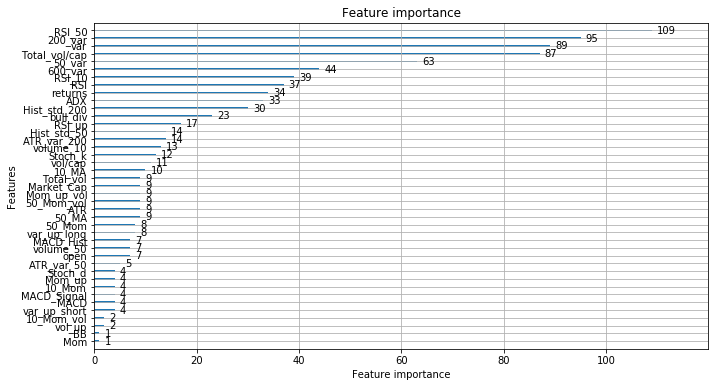

In [16]:
plt.rcParams["figure.figsize"]=[11,6]
lgb.plot_importance(xgb_gbm(True,test)[3],importance_type='split')



C:\Users\Jens\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


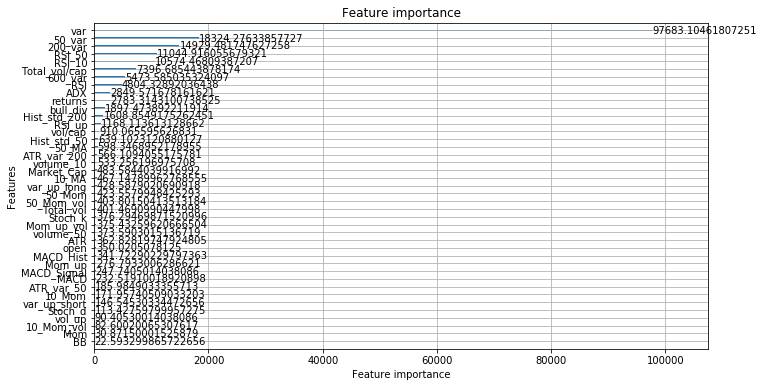

In [17]:
plt.rcParams["figure.figsize"]=[11,6]
lgb.plot_importance(xgb_gbm(True,test)[3],importance_type='gain')


In [18]:
def drawdowns(equity_curve):#Using cumulative returns curve, it calculates the greatest peak to through drawson
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)
    
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max()


def stats_v1(trades,test,y_pred,prob,t,direction):#quantify the performance of the strategy using metrics such as sharp,sortino and calmar ratios
    trades = trades[trades.pred>prob]
    if direction=='long':
        ret=trades.Pnl_Long
        bench=test.Pnl_Long
    else:
        ret=trades.Pnl_Short
        bench=test.Pnl_Short
    
    neg1=bench[bench<0]
    neg=ret[ret<0]
    col=['Mean_Return','Std','Count','Total','Sharpe','Sortino','Calmar','1day_Calmar']
    df=[ret.mean(),ret.std(),len(trades),ret.sum(),ret.mean()/ret.std(),ret.mean()/neg.std(),trades.cpl.max()/drawdowns(trades.cpl),ret.mean()/abs(ret.min())]
    df1=[bench.mean(),bench.std(),len(test),bench.sum(),bench.mean()/bench.std(),ret.mean()/neg1.std(),test.cpl.max()/drawdowns(test.cpl),bench.mean()/abs(bench.min())]
    df1=pd.DataFrame(df1)
    df1=df1.transpose()
    df1.columns=col
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    if t=='base':
        df=df.append(df1)
        df.index=['ML','Basic']
    return df


def opt_prob(direction):#displays how a trades performance varies with the models confidence in it being sucessful
    p=.5
    prob=[p]
    df=stats_v1(trades,test,y_pred,p,'t',direction)  
    
    for x in frange(.55,trades.pred.max(),.05):
        try:
            df=df.append(stats_v1(trades,test,y_pred,x,'t',direction))
            prob.append(x)
        except:
            break
            
    df.index=prob
    df=df.dropna()
    return df


res=opt_prob('long')#.1
res


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.864902,7.465231,4974.0,9276.022756,0.249812,0.431727,2.979578,0.077465
0.55,2.135507,7.603140,3965.0,8467.285982,0.280872,0.494596,2.979578,0.088706
0.60,2.435041,7.633606,3026.0,7368.435368,0.318990,0.590479,2.978746,0.101148
0.65,2.442896,7.538934,1979.0,4834.490742,0.324037,0.581752,2.981473,0.103661
0.70,2.698856,7.576679,1132.0,3055.105145,0.356206,0.599915,2.982260,0.114522
0.75,2.856962,8.180337,624.0,1782.744443,0.349247,0.583325,3.004794,0.128786
0.80,3.107459,8.693053,296.0,919.807738,0.357465,0.593254,2.872892,0.150450
0.85,2.477199,8.245522,95.0,235.333913,0.300430,0.460745,2.810645,0.119935


In [19]:
res=opt_prob('long')#.05 two day
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.864902,7.465231,4974.0,9276.022756,0.249812,0.431727,2.979578,0.077465
0.55,2.135507,7.603140,3965.0,8467.285982,0.280872,0.494596,2.979578,0.088706
0.60,2.435041,7.633606,3026.0,7368.435368,0.318990,0.590479,2.978746,0.101148
0.65,2.442896,7.538934,1979.0,4834.490742,0.324037,0.581752,2.981473,0.103661
0.70,2.698856,7.576679,1132.0,3055.105145,0.356206,0.599915,2.982260,0.114522
0.75,2.856962,8.180337,624.0,1782.744443,0.349247,0.583325,3.004794,0.128786
0.80,3.107459,8.693053,296.0,919.807738,0.357465,0.593254,2.872892,0.150450
0.85,2.477199,8.245522,95.0,235.333913,0.300430,0.460745,2.810645,0.119935


In [20]:
res=opt_prob('long')#.05 two day, ooptimised
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.864902,7.465231,4974.0,9276.022756,0.249812,0.431727,2.979578,0.077465
0.55,2.135507,7.603140,3965.0,8467.285982,0.280872,0.494596,2.979578,0.088706
0.60,2.435041,7.633606,3026.0,7368.435368,0.318990,0.590479,2.978746,0.101148
0.65,2.442896,7.538934,1979.0,4834.490742,0.324037,0.581752,2.981473,0.103661
0.70,2.698856,7.576679,1132.0,3055.105145,0.356206,0.599915,2.982260,0.114522
0.75,2.856962,8.180337,624.0,1782.744443,0.349247,0.583325,3.004794,0.128786
0.80,3.107459,8.693053,296.0,919.807738,0.357465,0.593254,2.872892,0.150450
0.85,2.477199,8.245522,95.0,235.333913,0.300430,0.460745,2.810645,0.119935


In [21]:
res=opt_prob('long')#.05
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.864902,7.465231,4974.0,9276.022756,0.249812,0.431727,2.979578,0.077465
0.55,2.135507,7.603140,3965.0,8467.285982,0.280872,0.494596,2.979578,0.088706
0.60,2.435041,7.633606,3026.0,7368.435368,0.318990,0.590479,2.978746,0.101148
0.65,2.442896,7.538934,1979.0,4834.490742,0.324037,0.581752,2.981473,0.103661
0.70,2.698856,7.576679,1132.0,3055.105145,0.356206,0.599915,2.982260,0.114522
0.75,2.856962,8.180337,624.0,1782.744443,0.349247,0.583325,3.004794,0.128786
0.80,3.107459,8.693053,296.0,919.807738,0.357465,0.593254,2.872892,0.150450
0.85,2.477199,8.245522,95.0,235.333913,0.300430,0.460745,2.810645,0.119935


In [ ]:
###LONG only strategy###


# print('Original PnL - No ML')

# test.plot(x=test.index,y='cpl',figsize=[10,5])
# plt.show()
# print('----------------')
# print('PnL with ML')
# trades.plot(x=trades.index,y='cpl',figsize=[10,5])
# plt.show()

In [ ]:
###SHORT only strategy###

# print('Original PnL - No ML')

# test.plot(x=test.index,y='cpl',figsize=[10,5])
# plt.show()
# print('----------------')
# print('PnL with ML')
# trades.plot(x=trades.index,y='cpl',figsize=[10,5])
# plt.show()

# Live trading

In [22]:
##### LIVE SECTION #####

def get_df(from_date, to_date,coin):
    date = to_date
    holder = []
    while date > from_date:
        data = get_hourly(date,coin,exchange='Bitfinex')
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    df.set_index('time', inplace=True)                  
    df.sort_index(ascending=True, inplace=True)
    df.to_csv("live_1h_"+coin + '.csv')
    print('Processed: ' + coin)
    return df


to_date=datetime.now()
from_date=to_date-timedelta(hours=1500)
start= time.mktime(from_date.timetuple())
end = time.mktime(to_date.timetuple())


for x in tickers:
    get_df(start,end,x[5:])

Processed: BTC
Processed: ETC
Processed: EOS
Processed: XMR
Processed: ETH
Processed: DASH
Processed: BAT
Processed: GNT
Processed: XRP
Processed: LTC
Processed: XLM
Processed: REP
Processed: ZEC
Processed: IOT
Processed: NEO
Processed: BCH
Processed: TRX
Processed: OMG
Processed: XTZ
Processed: BSV
Processed: MKR
Processed: ZRX
Processed: VET
Processed: BTG
Processed: ZIL


In [23]:
def retrieve_symbol_name_v2(coin,window):
    col=['date','close']
    ndf=pd.read_csv("live_1h_"+coin+'.csv',index_col='time')
    ndf=ndf.drop(["volumefrom"],axis=1)
    ndf.index=pd.to_datetime(ndf.index)
    df=pd.DataFrame()
    unique_dates=ndf.index.drop_duplicates(keep='first')
    for i in unique_dates:
        if len(ndf.loc[i])>2:
            df=df.append(ndf.loc[i])
        else:
            df=df.append(ndf.loc[i].iloc[1,:])
    df['returns']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    div=divergence(df['close'],df['RSI'],24*4,window,70,30)
    df['bull_div']=0
    df['bull_div'].iloc[div[0]]=1
    df['bear_div']=0
    df['bear_div'].iloc[div[1]]=1
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['var']=df['returns'].rolling(50).var()
    df['50_var']=df['var'].rolling(50).mean()
    df['200_var']=df['var'].rolling(200).mean()
    df['600_var']=df['var'].rolling(600).mean()
    df['var_up_short']= (df['50_var']> df['200_var']).astype(float)
    df['var_up_long']= (df['200_var']> df['600_var']).astype(float)
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['ATR_var_50']=df['ATR'].rolling(50).var()
    df['ATR_var_200']=df['ATR'].rolling(200).var()
    df['50_Std']=df['returns'].rolling(50).std()
    df['rise']=(df['returns']>2*df['50_Std']).astype(float)
    df['fall']=(df['returns']<-2*df['50_Std']).astype(float)
    df['rise2']=(df['returns']>3.5*df['50_Std']).astype(float)
    df['fall2']=(df['returns']<-3.5*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std_50']=df['MACD_Hist_change'].rolling(50).std()
    df['Hist_std_200']=df['MACD_Hist_change'].rolling(200).std()
    df['MACD_signal']=(df['Hist_std_50']>df['Hist_std_200']).astype(float)
    df['Mom'] = talib.MOM(close, timeperiod=window)
    df['10_Mom']=df['Mom'].rolling(10).mean()
    df['10_Mom_vol']=df['10_Mom'].rolling(10).var()
    df['50_Mom']=df['Mom'].rolling(50).mean()
    df['50_Mom_vol']=df['50_Mom'].rolling(50).var()
    df['Mom_up']=(df['10_Mom']> df['50_Mom']).astype(float)
    df['Mom_up_vol']=(df['10_Mom_vol']> df['50_Mom_vol']).astype(float)
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Stoch_k']=slowk
    df['Stoch_d']=slowd
    df['BB']=bbp(close)
    df.index=pd.to_datetime(df.index)
    df=df.dropna()
    hour=[]
    for i in df.index:
        hour.append(int(str(i)[11:13]))
    df['hour']=hour
    from_date = (df.index[0]-timedelta(hours=24))
    to_date=df.index[-1]
    start= int(time.mktime(from_date.timetuple()))
    end = int(time.mktime(to_date.timetuple()))
    try:
        cap=coin_metrics('cap',coin.lower(),start,end)
        cap=cap[cap.index>df.index[0]]
        vol=coin_metrics('vol',coin.lower(),start,end)
        vol=vol[vol.index>df.index[0]]
    except:
        cap=0
        vol=0
    df['Market_Cap']=cap
    df['Total_vol']=vol
    df['vol/cap']=df['volumeto']/df['Market_Cap']
    df['Total_vol/cap']=df['Total_vol']/df['Market_Cap']
    return df

def all_coins_live():
    start=time.time()
    df=retrieve_symbol_name_v2('BTC',14)
    for x in tickers[1:]:
        df=df.append(retrieve_symbol_name_v2(x[5:],14))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df

live=all_coins_live()

C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Runtime is 71.7982873916626 seconds


In [24]:
def prep_data(lookback): # return df for a specified lookback period in hours up till the hour of datetime.now()
    
    to_date=datetime.now()
    from_date=to_date-timedelta(hours=lookback)
    start= time.mktime(from_date.timetuple())
    end = time.mktime(to_date.timetuple())
    startt=time.time()
    df=get_df(start,end,'BTC')
    df['coin']='BTC'
    for x in tickers[1:]:
        new=get_df(start,end,x[5:])
        new['coin']=x[5:]         
        df=df.append(new) 
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-startt)+" seconds")
    return df
    


def latest(): # return df with the latest hour of data for our tickers
    
    to_date=datetime.now()
    from_date=to_date-timedelta(hours=1)
    start= time.mktime(from_date.timetuple())
    end = time.mktime(to_date.timetuple())
    startt=time.time()
    df=get_df(start,end,'BTC')
    df['coin']='BTC'
    for x in tickers[1:]:
        new=get_df(start,end,x[5:])
        new['coin']=x[5:]
        df=df.append(new)
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-startt)+" seconds")
    return df
prep=prep_data(500)
prep.tail()

Processed: BTC
Processed: ETC
Processed: EOS
Processed: XMR
Processed: ETH
Processed: DASH
Processed: BAT
Processed: GNT
Processed: XRP
Processed: LTC
Processed: XLM
Processed: REP
Processed: ZEC
Processed: IOT
Processed: NEO
Processed: BCH
Processed: TRX
Processed: OMG
Processed: XTZ
Processed: BSV
Processed: MKR
Processed: ZRX
Processed: VET
Processed: BTG
Processed: ZIL
Runtime is 17.928065061569214 seconds


,close,high,low,open,volumefrom,volumeto,coin
time,,,,,,,
2019-05-25 13:00:00,7.28000,7.310000,7.24000,7.310000,394.18,2862.26,ETC
2019-05-25 13:00:00,0.00746,0.007578,0.00746,0.007578,742.76,5.54,VET
2019-05-25 13:00:00,8043.50000,8094.400000,8042.80000,8092.700000,140.73,1133546.98,BTC
2019-05-25 13:00:00,0.09629,0.096290,0.09629,0.096290,0.00,0.00,GNT
2019-05-25 13:00:00,0.02267,0.022670,0.02267,0.022670,0.00,0.00,ZIL


In [25]:
def retrieve_data_live(df,window):
    startt=time.time()
    df=df.append(latest())
    df=df.drop(['volumefrom'],axis=1)
    df['returns']=df['close'].pct_change()
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    div=divergence(df['close'],df['RSI'],24*4,window,70,30)
    df['bull_div']=0
    df['bull_div'].iloc[div[0]]=1
    df['bear_div']=0
    df['bear_div'].iloc[div[1]]=1
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['var']=df['returns'].rolling(50).var()
    df['50_var']=df['var'].rolling(50).mean()
    df['200_var']=df['var'].rolling(200).mean()
    df['1000_var']=df['var'].rolling(1000).mean()
    df['var_up_short']= (df['50_var']> df['200_var']).astype(float)
    df['var_up_long']= (df['200_var']> df['1000_var']).astype(float)
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['50_Std']=df['returns'].rolling(50).std()
    df['rise']=(df['returns']>2*df['50_Std']).astype(float)
    df['fall']=(df['returns']<-2*df['50_Std']).astype(float)
    df['rise2']=(df['returns']>3.5*df['50_Std']).astype(float)
    df['fall2']=(df['returns']<-3.5*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std']=df['MACD_Hist_change'].rolling(50).std()
    df['MACD_signal']=(df['MACD_Hist_change']>df['Hist_std']).astype(float)
    df['Mom'] = talib.MOM(close, timeperiod=window)
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Stoch_k']=slowk
    df['Stoch_d']=slowd
    df['BB']=bbp(close)
    df.index=pd.to_datetime(df.index)
    df=df.dropna()
    hour=[]
    for i in df.index:
        hour.append(int(str(i)[11:13]))
    df['hour']=hour
    from_date = (df.index[0]-timedelta(hours=24))
    to_date=df.index[-1]
    start= int(time.mktime(from_date.timetuple()))
    end = int(time.mktime(to_date.timetuple()))
    try:
        cap=coin_metrics('cap',coin.lower(),start,end)
        cap=cap[cap.index>df.index[0]]
        vol=coin_metrics('vol',coin.lower(),start,end)
        vol=vol[vol.index>df.index[0]]
    except:
        cap=0
        vol=0
    df['Market_Cap']=cap
    df['Total_vol']=vol
    df['vol/cap']=df['volumeto']/df['Market_Cap']
    df['Total_vol/cap']=df['Total_vol']/df['Market_Cap']
    print ("Runtime is " +str(time.time()-startt)+" seconds")
    return df
live=retrieve_data_live(prep,14)
live.tail()

Processed: BTC
Processed: ETC
Processed: EOS
Processed: XMR
Processed: ETH
Processed: DASH
Processed: BAT
Processed: GNT
Processed: XRP
Processed: LTC
Processed: XLM
Processed: REP
Processed: ZEC
Processed: IOT
Processed: NEO
Processed: BCH
Processed: TRX
Processed: OMG
Processed: XTZ
Processed: BSV
Processed: MKR
Processed: ZRX
Processed: VET
Processed: BTG
Processed: ZIL
Runtime is 14.098397254943848 seconds


C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Runtime is 14.63881254196167 seconds


,close,high,low,open,volumeto,coin,returns,RSI,RSI_10,RSI_50,...,MACD_signal,Mom,Stoch_k,Stoch_d,BB,hour,Market_Cap,Total_vol,vol/cap,Total_vol/cap
time,,,,,,,,,,,,,,,,,,,,,
2019-05-25 13:00:00,701.24000,701.240000,701.24000,701.240000,0.00,MKR,6.760514,52.039386,48.751483,49.670883,...,0.0,700.88020,40.786209,16.228002,1.378781,13,0,0,NaN,NaN
2019-05-25 13:00:00,0.31310,0.314800,0.31310,0.314800,5728.74,ZRX,-0.999554,48.061254,48.742005,49.664467,...,0.0,0.21681,40.657909,29.685099,0.361986,13,0,0,inf,NaN
2019-05-25 13:00:00,0.00746,0.007578,0.00746,0.007578,5.54,VET,-0.976174,48.059529,48.712798,49.663566,...,0.0,-0.37904,33.333333,38.259151,0.362139,13,0,0,inf,NaN
2019-05-25 13:00:00,22.77000,22.840000,22.74000,22.840000,2422.11,BTG,3051.278820,48.208639,48.725051,49.663656,...,0.0,-78.56000,1.082025,25.024423,0.400171,13,0,0,inf,NaN
2019-05-25 13:00:00,0.02267,0.022670,0.02267,0.022670,0.00,ZIL,-0.999004,48.060155,48.717753,49.662731,...,0.0,-0.10343,1.082748,11.832702,0.383492,13,0,0,NaN,NaN


In [34]:
def all_trades(features_df, pred_treshold, trained_model='xg_boost_long'):  

    features=features_df.columns
    features=list(features)
    x=['coin']
    features=[e for e in features if e not in x]

    X_live=features_df.loc[:,features]

    #load our trained model
    filename = trained_model
    infile = open(filename,'rb')
    bst = pickle.load(infile)
    infile.close()

    y_pred = bst.predict(X_live)
    trades = features_df.assign(pred = y_pred)
    trades = trades[trades.pred >pred_treshold]
    return trades

def filter_trades(trades):
    
    try: 
        filtered_trades = trades[trades.index == trades.index[-1]]
        
        return filtered_trades

    except:
        
        print ("no trades at this prediction level, lower prediction level")
        
    
    
filter_trades(all_trades(live,0.5))



,close,high,low,open,volumeto,coin,returns,RSI,RSI_10,RSI_50,...,Mom,Stoch_k,Stoch_d,BB,hour,Market_Cap,Total_vol,vol/cap,Total_vol/cap,pred
time,,,,,,,,,,,,,,,,,,,,,
2019-05-25 13:00:00,0.00746,0.007578,0.00746,0.007578,5.54,VET,-0.998975,47.930758,49.285866,49.174904,...,-407.40254,0.331318,11.331990,0.369158,13,0,0,inf,NaN,0.570539
2019-05-25 13:00:00,0.09629,0.096290,0.09629,0.096290,0.00,GNT,-0.999988,48.108812,52.813109,49.883693,...,0.06840,33.124089,22.303483,0.429305,13,0,0,NaN,NaN,0.555535
2019-05-25 13:00:00,0.02267,0.022670,0.02267,0.022670,0.00,ZIL,-0.764565,48.108611,52.544887,49.873052,...,-0.33713,33.124152,33.234427,0.429295,13,0,0,NaN,NaN,0.555535
2019-05-25 13:00:00,0.35980,0.359800,0.35980,0.359800,25.18,BAT,-0.997704,48.089481,53.471806,50.166248,...,-700.88020,21.036146,14.606866,0.407170,13,0,0,inf,NaN,0.519961
2019-05-25 13:00:00,0.09629,0.096290,0.09629,0.096290,0.00,GNT,-0.732379,48.088850,49.926238,50.140655,...,-6.26371,20.029310,20.819763,0.407258,13,0,0,NaN,NaN,0.555535


# CCXT execution

In [48]:
import ccxt
#import ccxt.async_support as ccxt # link against the asynchronous version of ccxt
print(ccxt.__version__)

1.18.504


In [49]:
binance_key = "X1rCkHZYnKmNCB4DwQHSbGQ0ykKRKbg0hE1kvEOPPeRoZcbRSaO2XlrRB6WMYYgV"
secret_binance = "4n4YBqtOeNq1cvsQUmIhC2SiJpUrj9amcxdQ2bPjwT04da7OmKR4TqwaOdnGacU8"

In [50]:
# initializing the exchange
binance_ex = ccxt.binance ({
    'apiKey': binance_key,
    'secret': secret_binance,
    'options': { 'adjustForTimeDifference': True } # this line is crucial for binance else we're getting an error. it doesn't necessarily apply to other exchanges
})

In [451]:
USDT_symbols_binance = [symbol for symbol in binance_ex.symbols if 'USDT' in symbol]
modified_tickers = [symbol[5:] for symbol in tickers]
symbols = [symbol+'/USDT' for symbol in modified_tickers if symbol+'/USDT' in l] # the available symbols on binance
print (symbols)

['BTC/USDT', 'ETC/USDT', 'EOS/USDT', 'XMR/USDT', 'ETH/USDT', 'DASH/USDT', 'BAT/USDT', 'XRP/USDT', 'LTC/USDT', 'XLM/USDT', 'ZEC/USDT', 'NEO/USDT', 'BCH/USDT', 'TRX/USDT', 'OMG/USDT', 'BSV/USDT', 'ZRX/USDT', 'VET/USDT', 'ZIL/USDT']


In [ ]:
def min_notational_value(exchange, symbol): # WIP, this function isn't optimized. eg if the max ask would be very high, the calculation would be way too high
    
    cost = exchange.markets[symbol]['limits']['cost']['min'] # this is the minimum order value in terms of quote pair
    
    '''
    calculate the minimum order value for the base pair. 
    eg XRP/BTC we retrieve the ask price for XRP and divide the minimum order value of BTC by that ask price
    eg min order value in BTC = 0.001, XRP ask = 0.00005
    ==> minimum order of XRP has to be 0.001/0.00005 = 20 XRP
    
    take rounding issues into account!! 
    
    eg BTC/USDT we retrieve the ask price and divide the minimum order value of 10 USDT by that ask price
    eg min order value in USDT = 10, BTC/USDT ask = 7958
    ==> mimimum order of BTC has to be 10 / 7958 = 0.0012550
    '''
    
    orderbook = exchange.fetch_order_book(symbol)
    ask = (max(pd.DataFrame(exchange.fetchTrades(symbol))['price']))*.99 if len (pd.DataFrame(exchange.fetchTrades(symbol))['price']) > 0 else None
    
    '''
    *.99 :
    when we calculate the minimum notational value, for some reason it doesn't always goes through. I've tried
    to build in this buffer so we buy a little bit more than the calculated minimum notational value which seems to go through   
    '''
    
    if ask == None:
        return "no asks in orderbook"
    else:    
        min_order = cost/ask
        return min_order

    
symbol = 'BTC/USDT'
symbol, min_notational_value(binance_ex,symbol)

In [453]:
def execution(hour, window, prob_treshold, exchange=binance_ex): # WE NEED TO MAKE SURE THAT THE SYMBOLS TRADED ARE ONES AVAILABLE ON BINANCE WIP
# hour at which we execute the trade, windown for the prepared data, window for the prepped data
    
    now = datetime.now()
    
    while now.hour != hour: # check what minute it is now. we'll then wait till we're at minute 59
        time.sleep((59-now.minute)*60) 
        prep=prep_data(window)
        
    while datetime.now.minute != 0 : # snooze till we're at exactly the hour
        
        time.sleep(1) 
        live=retrieve_data_live(prep,14) # at the hour we retrieve the latest prices and append them to the prepped data
        trades = filter_trades(all_trades(live,prob_treshold)) # filter the trades for this hour dependent on the probability of trades we want to take
        highest_probability_trade = trades[trades.pred == trades.pred.max()] # take the trade with the highest probability
        symbol = highest_probability_trade['coin'][0]
        symbol = symbol+'/USDT'
    
        order = exchange.create_order(symbol, ordertype='market', side='buy', amount=min_notational_value(binance_ex,symbol))
        print(order)


In [392]:
# do not run this code as it will execute an order

'''
#symbol='XRP/BTC' # when we buy, we buy XRP with BTC. order would be in XRP amount
# when we sell, we sell BTC for XRP. order would also be in XRP amount
symbol = 'BTC/USDT'
ordertype='market'
side='buy'
amount= min_notational_value(binance_ex,symbol)
price = None # how much quote currency you are willing to pay for a trade lot of base currency (for limit orders only)
order = binance_ex.create_order(symbol, ordertype, side, amount, params)
'''

InsufficientFunds: binance Account has insufficient balance for requested action.

In [452]:
binance_ex.fetchBalance()

{'info': {'makerCommission': 10,
  'takerCommission': 10,
  'buyerCommission': 0,
  'sellerCommission': 0,
  'canTrade': True,
  'canWithdraw': True,
  'canDeposit': True,
  'updateTime': 1558881396871,
  'accountType': 'MARGIN',
  'balances': [{'asset': 'BTC', 'free': '0.09691364', 'locked': '0.00000000'},
   {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'BNB', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'USDT',